In [ ]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2
import subprocess
from PIL import Image
from IPython.display import clear_output

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Inpainting

In [ ]:
fastsam_first_time_flag = True
ldm_first_time_flag = True

Fetch images from you google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Write a path to you image on the drive into `drive_image_path` variable.

(It is the only thing needed to be changed in this whole code)

In [ ]:
drive_image_path = "drive/MyDrive/skoltech/isp_course/image_examples/inpainting/img_0.png"

In [ ]:
INPUT_DIR = "inpaiting/input_images"
OUTPUT_DIR = "inpaiting/output"
subprocess.run(f"mkdir -p {INPUT_DIR}".split())
subprocess.run(f"mkdir -p {OUTPUT_DIR}".split())

CompletedProcess(args=['mkdir', '-p', 'inpaiting/output'], returncode=0)

In [ ]:
output_image_dir = f"{OUTPUT_DIR}/{drive_image_path.split('/')[-1].split('.')[0]}"
image_dir =  f"{INPUT_DIR}/{drive_image_path.split('/')[-1].split('.')[0]}"
image_path = f"{image_dir}/img.png"
subprocess.run(f"mkdir -p {output_image_dir}".split())
subprocess.run(f"mkdir -p {image_dir}".split())
subprocess.run(f"cp {drive_image_path} {image_path}".split())

CompletedProcess(args=['cp', 'drive/MyDrive/skoltech/isp_course/image_examples/inpainting/img_0.png', 'inpaiting/input_images/img_0/img.png'], returncode=0)

Let's plot the image

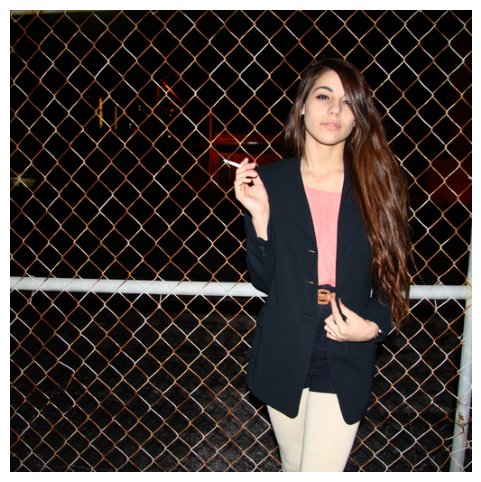

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(image)

## FastSam for object detection

It will help to detect natural areas of an image which we can be deleted.

### Setting environment and loading a model

In [ ]:
if fastsam_first_time_flag:
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git

    !pip install -r FastSAM/requirements.txt
    !pip install git+https://github.com/openai/CLIP.git

    !mkdir fast_sam_weights
    !wget -O fast_sam_weights/FastSAM.pt https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
    fastsam_first_time_flag = False
    clear_output()

### Objects detection

In [ ]:
from FastSAM.fastsam import FastSAM

%env PYTHONPATH=/content
model = FastSAM("/content/fast_sam_weights/FastSAM.pt")
IMAGE_PATH = image_path
DEVICE = 'cpu'
everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9,)

env: PYTHONPATH=/content



image 1/1 /content/inpaiting/input_images/img_0/img.png: 1024x1024 15 objects, 13499.9ms
Speed: 20.5ms preprocess, 13499.9ms inference, 101.6ms postprocess per image at shape (1, 3, 1024, 1024)


Let's plot found masks.

In [ ]:
masks = everything_results[0].masks
for i, mask in enumerate(masks):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    fig.suptitle(f"mask_idx: {i}")
    axes[0].imshow(image * (1 - mask.data[0][:, :, None].numpy().astype("int")))
    axes[0].set_title("masked_image")
    axes[0].axis("off")
    axes[1].imshow(mask.data[0], cmap="gray")
    axes[1].set_title("mask")
    axes[1].axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Let's combine gotten masks into one.

Choose masks indices for that (`maks_idcs` variable).

In [ ]:
masks_idcs = [1, 3, 14]
result_mask = np.zeros(image.shape[:-1])
for mask_idx in masks_idcs:
    mask = masks[mask_idx]
    result_mask += mask.data[0].numpy()
result_mask = np.where(result_mask > 0, 1, 0)


Let's plot it

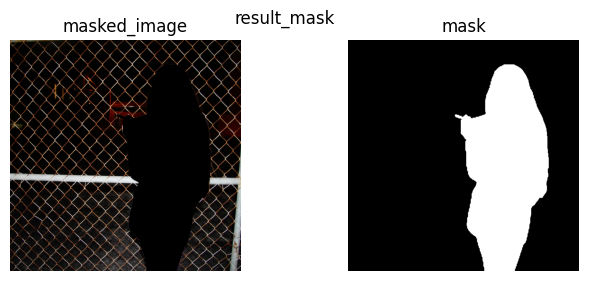

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.suptitle(f"result_mask")
axes[0].imshow(image * (1 - result_mask[:, :, None]))
axes[0].set_title("masked_image")
axes[0].axis("off")
axes[1].imshow(result_mask, cmap="gray")
axes[1].set_title("mask")
axes[1].axis("off")
plt.show()

In [ ]:
# putting `result_mask` image into the image_dir
Image.fromarray(np.uint8(result_mask * 255)).save(f"{image_dir}/img_mask.png")

## Latent Diffusion Model for inpainting

### Setting environment and loading a model

In [ ]:
if ldm_first_time_flag:
    !git clone https://github.com/CompVis/latent-diffusion.git

    !pip install transformers==4.19.2 scann kornia==0.6.4 torchmetrics==0.6.0
    !pip install git+https://github.com/arogozhnikov/einops.git
    !pip install omegaconf
    !pip install pytorch-lightning==1.6.5
    !pip install taming-transformers
    !pip install taming-transformers-rom1504

    !mkdir -p latent-diffusion/models/ldm/inpainting_big/
    !wget -O latent-diffusion/models/ldm/inpainting_big/last.ckpt https://heibox.uni-heidelberg.de/f/4d9ac7ea40c64582b7c9/?dl=1

    ldm_first_time_flag = False
    clear_output()

### Inferring a diffusion model

Here we give our image and built mask to the diffusion model and it outputs the image, where the masked object is inpainted.

In [ ]:
n_ddim_steps = 50

%env PYTHONPATH=/content/latent-diffusion
%cd latent-diffusion
command = f"python scripts/inpaint.py --indir /content/{image_dir} --outdir /content/{output_image_dir} --steps {n_ddim_steps}"
result = subprocess.run(command, shell=True, capture_output=True, text=True)
%cd ..

clear_output()
print(f"output_dir: {output_image_dir}")

output_dir: inpaiting/output/img_0


Let's plot the result.

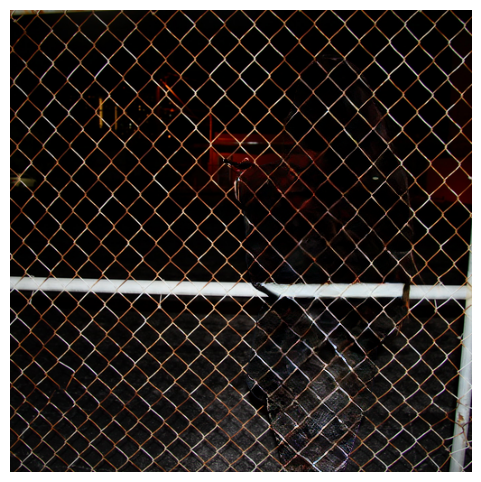

In [ ]:
ouptut = cv2.imread(f"{output_image_dir}/img.png")
ouptut = cv2.cvtColor(ouptut, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(ouptut)

# Superresolution

In [ ]:
sr_first_time_flag = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_image_path = "drive/MyDrive/skoltech/isp_course/image_examples/superresolution/img_0.png"

In [ ]:
INPUT_DIR = "superresolution/input_images"
OUTPUT_DIR = "superresolution/output"
subprocess.run(f"mkdir -p {INPUT_DIR}".split())
subprocess.run(f"mkdir -p {OUTPUT_DIR}".split())

CompletedProcess(args=['mkdir', '-p', 'superresolution/output'], returncode=0)

In [ ]:
image_name = drive_image_path.split("/")[-1].split(".")[0]
image_path = f"{INPUT_DIR}/{image_name}.png"
subprocess.run(f"cp {drive_image_path} {image_path}".split())

CompletedProcess(args=['cp', 'drive/MyDrive/skoltech/isp_course/image_examples/superresolution/img_0.png', 'superresolution/input_images/img_0.png'], returncode=0)

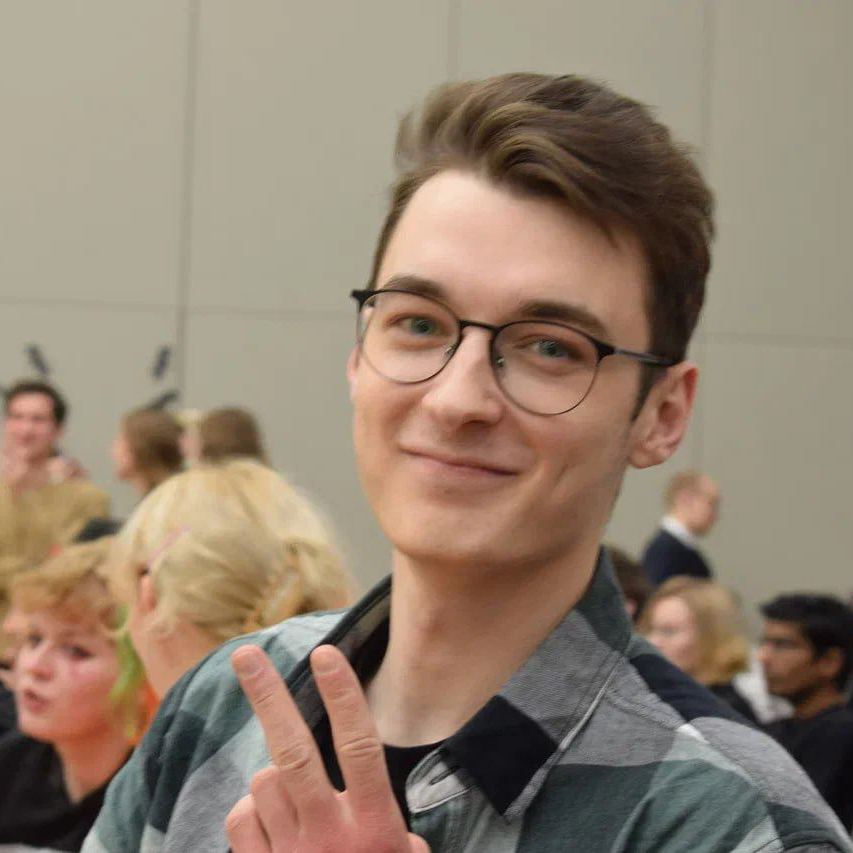

In [ ]:
image = Image.open(image_path)
image

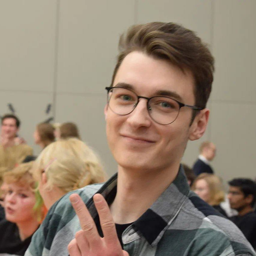

In [ ]:
lowres_size = 256
lowres_image = image.resize((lowres_size, lowres_size))
lowres_image

# Setting environment and loading a model

In [ ]:
if sr_first_time_flag:
    !pip install git+https://github.com/huggingface/diffusers.git
    from diffusers import LDMSuperResolutionPipeline

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_id = "CompVis/ldm-super-resolution-4x-openimages"
    sr_pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
    sr_pipeline = sr_pipeline.to(device)

    clear_output()
    sr_first_time_flag = False


In [ ]:
output_path

'superresolution/output/img_0'

In [ ]:
upscaled_image = model(lowres_image, num_inference_steps=100, eta=1).images[0]

output_path = f"{OUTPUT_DIR}/{image_name}.png"
upscaled_image.save(output_path)


  0%|          | 0/100 [00:00<?, ?it/s]

Let's plot the result

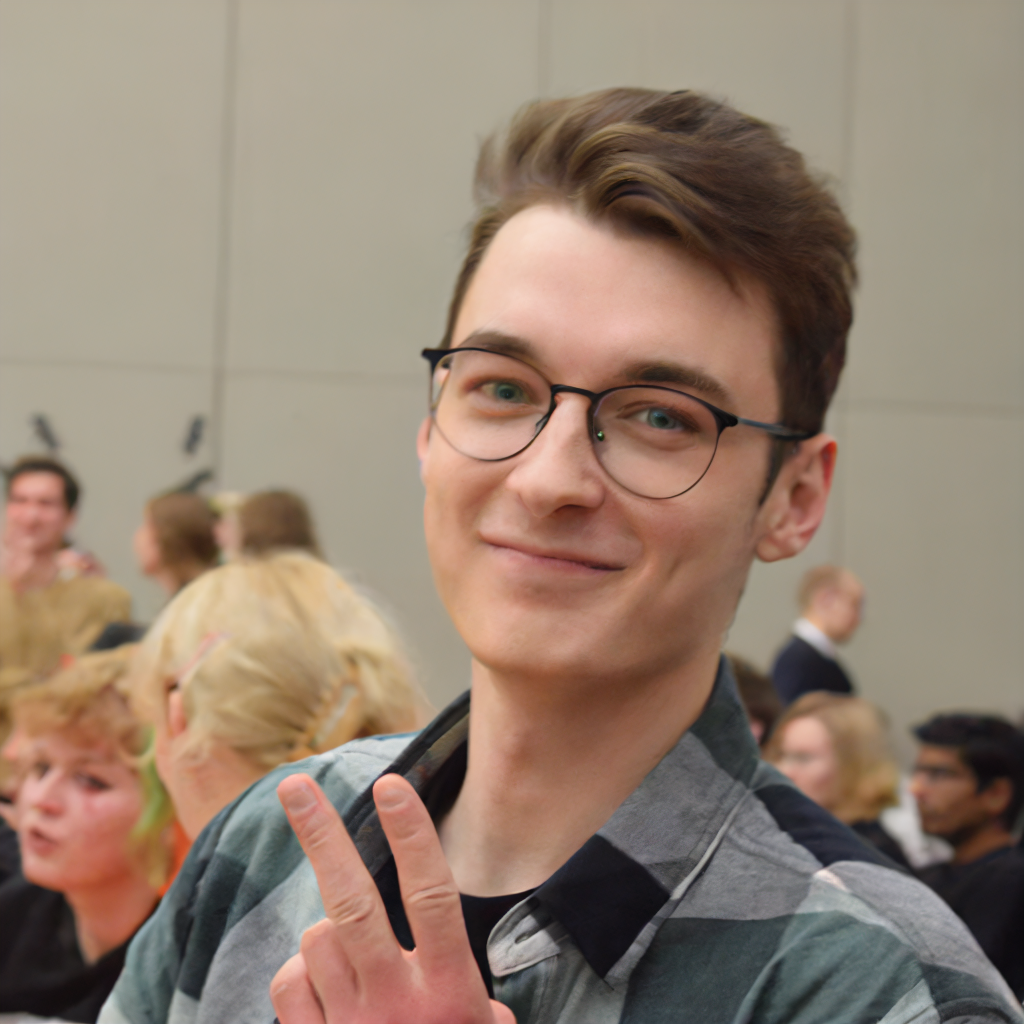

In [ ]:
upscaled_image